# Mental Health Analysis ProjectA 

The purpose of this project is ...

# Data Scrapping

Reddit data

In [7]:
# scrapping data from reddit api
import requests
import pandas as pd
# import praw
import emoji
import emot
import asyncpraw
# import asyncio
from tqdm import tqdm
# loading json
import json
# load a kaomoji_to_text.json
kaomoji_to_text = json.load(open('./kaomoji_to_text.json', 'r', encoding='utf-8'))


import os
from dotenv import load_dotenv
load_dotenv()




class RedditScraper:


    def __init__(self):

        self.auth = requests.auth.HTTPBasicAuth(os.getenv('CLIENT_ID'), os.getenv('CLIENT_SECRET'))
        self.data = {'grant_type': 'password',
                     'username': os.getenv('USERNAME'),
                     'password': os.getenv('PASSWORD')}
        self.headers = {'User-Agent': 'MyAPI/0.0.1'}
        self.res = requests.post('https://www.reddit.com/api/v1/access_token',
                                auth=self.auth, data=self.data, headers=self.headers)
        
        self.headers["Authorization"] = f'bearer {self.res.json()["access_token"]}'



        self.client_id = os.getenv('CLIENT_ID')
        self.client_secret = os.getenv('CLIENT_SECRET')
        self.username = os.getenv('USERNAME')
        self.password = os.getenv('PASSWORD')





    def get_posts_byrequests(self, subreddit, limit=1000):
        url = f'https://oauth.reddit.com/r/{subreddit}/hot'
        params = {'limit': limit}
        response = requests.get(url, headers=self.headers, params=params)
        
        if response.status_code == 200:
            return response
        else:
            raise Exception(f"Error fetching posts: {response.status_code} - {response.text}")
        


    def convert_emojis_emoticons(self, text):


        # Replace kaomojis with their text equivalents
        for kaomoji, text_representation in kaomoji_to_text.items():
            # if kaomoji is in text, replace it with text_representation
            if kaomoji in text:
                text = text.replace(kaomoji, f" {text_representation} ")


        e = emot.core.emot()

        # Extract emoticons
        emoticon_results = e.emoticons(text)
        for original, meaning in zip(emoticon_results['value'], emoticon_results['mean']):
            text = text.replace(original, f" {meaning} ")

        # Extract emojis
        # emoji_results = e.emoji(text)
        # for original, meaning in zip(emoji_results['value'], emoji_results['mean']):
        #     text = text.replace(original, f" {meaning} ")
        
        # Extract emojis
        text = emoji.demojize(text)


        return text.strip().lower()
        


    async def get_posts_byprawn(self, subreddits, limit=1000, mental="mental_"):

        reddit = asyncpraw.Reddit(client_id=self.client_id,
                             client_secret=self.client_secret,
                             user_agent='windows:mentalhealth.scraper:v1.0 (by u/IceWorth5480)',
                             username=self.username,
                             password=self.password)
        
        all_posts = []
        # , 'top', 'new'
        sort_types = ['hot', 'top', 'new']


        for subreddit_name in tqdm(subreddits, desc="Subreddits Progress"):
            subreddit = await reddit.subreddit(subreddit_name)
            for sort in sort_types:
                if sort == 'hot':
                    posts = subreddit.hot(limit=limit)
                elif sort == 'top':
                    posts = subreddit.top(limit=limit)
                elif sort == 'new':
                    posts = subreddit.new(limit=limit)

                async for post in posts:
                    if post is None:
                        continue

                    # Load top-level comments (non-blocking)
                    await post.load()
                    await post.comments.replace_more(limit=0)
                    top_comments_raw = [comment.body for comment in post.comments[:5]]  # Get top 5 comments
                    top_comments = [self.convert_emojis_emoticons(c) for c in top_comments_raw]

                    all_posts.append({
                        'id': post.id,
                        'subreddit': subreddit_name,
                        'sort': sort,
                        'title': post.title,
                        'selftext': self.convert_emojis_emoticons(post.selftext),
                        'created_utc': post.created_utc,
                        'score': post.score,
                        'num_comments': post.num_comments,
                        'author': str(post.author),
                        'post_url': post.url,
                        'over_18': post.over_18,
                        'flair': post.link_flair_text,
                        'top_comments': top_comments
                    })

        await reddit.close()



        df = pd.DataFrame(all_posts)
        # Drop duplicates by post ID
        df = df.drop_duplicates(subset='id').reset_index(drop=True)
        df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
        df = df.sort_values(by='created_utc', ascending=False).reset_index(drop=True)
        # Convert list of comments to string for CSV storage
        df['top_comments'] = df['top_comments'].apply(lambda x: ' | '.join(x) if isinstance(x, list) else '')



        # check if f'./data/reddit_data/{mental}reddit_posts.csv' exists, if so merging with df and # delete dupicates by id
        if os.path.exists(f'./data/reddit_data/{mental}reddit_posts.csv'):
            existing_df = pd.read_csv(f'./data/reddit_data/{mental}reddit_posts.csv')
            df = pd.concat([existing_df, df]).drop_duplicates(subset='id').reset_index(drop=True)
       
        # save as csv 
        df.to_csv(f'./data/reddit_data/{mental}reddit_posts.csv', index=False)


In [9]:



mental_subreddits = ['mentalhealth', 'depression', 'anxiety', 'therapy', 'selfhelp', 'bpd', 'ptsd', 'socialanxiety', 'counseling']
normal_subreddits = ['popular','all','AskReddit','interestingasfuck']
# australian_regions = ['melbourne','sydney','adelaide','perth','brisbane','canberra']


scraper  = RedditScraper()

await scraper.get_posts_byprawn(mental_subreddits, limit=1000, mental="mental_")
# await scraper.get_posts_byprawn(normal_subreddits, limit=1000, mental="normal_")




Subreddits Progress: 100%|██████████| 9/9 [6:13:00<00:00, 2486.67s/it]  


In [ ]:
# read the csv file 

df_mental = pd.read_csv('./data/reddit_data/mental_reddit_posts.csv')
print(df_mental.shape)

df_normal = pd.read_csv('./data/reddit_data/normal_reddit_posts.csv')
print(df_normal.shape)

(7646, 13)
(180, 13)


Beyond Blue forums 

In [ ]:
'''
TO DO

Extract following information from the reddit webpage 


Post ID: A unique identifier for each post.
Post Content: The text of the post.
Post Author: The author of the post.
Post Date: The date the post was made.
Post Category: Category or forum where the post was made.
Number of Comments: The total number of comments on the post.

From Comment 

Post ID: Link back to the original post.
Comment ID: A unique identifier for each comment.
Comment Content: Text of the comment.
Comment Author: Author of the comment.
Comment Date: Date the comment was posted. (the order of the comments is really important)
other meta data if available
'''



from bs4 import BeautifulSoup
import pandas as pd
import time
import re
from datetime import datetime, timedelta
import calendar
import os


from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, WebDriverException

from tqdm import tqdm
import emoji
import emot
# loading json
import json
# load a kaomoji_to_text.json
kaomoji_to_text = json.load(open('./kaomoji_to_text.json', 'r', encoding='utf-8'))




def parse_post_date(raw_date):

    weekdays = [day.lower() for day in list(calendar.day_name) ]
    today = datetime.now()

    raw_date = raw_date.strip().lower()  

    # Case 1: Day of the week (e.g., "Monday")
    if raw_date in weekdays:
        # Get weekday index: Monday = 0, Sunday = 6
        post_weekday_index = weekdays.index(raw_date)
        today_weekday_index = today.weekday()

        # Calculate difference in days
        delta_days = (today_weekday_index - post_weekday_index) % 7
        # Get actual date
        post_date = today - timedelta(days=delta_days)
        return post_date.strftime('%Y-%m-%d')  # Format as YYYY-MM-DD
    
    # Case 2: "a week ago", "2 weeks ago", etc.
    elif "week" in raw_date:
        match = re.search(r'(\d+)', raw_date)
        weeks = int(match.group(1)) if match else 1
        post_date = today - timedelta(weeks=weeks)
        return post_date.strftime('%Y-%m-%d')

    # Case 3: "a month ago", "2 months ago", etc.
    elif "month" in raw_date:
        match = re.search(r'(\d+)', raw_date)
        months = int(match.group(1)) if match else 1
        # Approximate a month as 30 days
        post_date = today - timedelta(days=30 * months)
        return post_date.strftime('%Y-%m-%d')
    
    # Case 4: Exact date format like "11-05-2025"
    else:
        # Try parsing date in the format like "25-09-2020"
        try:
            post_date = datetime.strptime(raw_date, '%d-%m-%Y')
            return post_date.strftime('%Y-%m-%d')
        except ValueError:
            return 'Unknown date'  # If format is unexpected




def convert_emojis_emoticons(text):


    # Replace kaomojis with their text equivalents
    for kaomoji, text_representation in kaomoji_to_text.items():
        # if kaomoji is in text, replace it with text_representation
        if kaomoji in text:
            text = text.replace(kaomoji, f" {text_representation} ")


    e = emot.core.emot()

    # Extract emoticons
    emoticon_results = e.emoticons(text)

    for original, meaning in zip(emoticon_results['value'], emoticon_results['mean']):
        text = text.replace(original, f" {meaning} ")

    # # Extract emojis
    # emoji_results = e.emoji(text)
    # for original, meaning in zip(emoji_results['value'], emoji_results['mean']):
    #     text = text.replace(original, f" {meaning} ")

    text = emoji.demojize(text)


    return text.strip().lower()




def comment_scrapping (url, comment_pages = 1,wait_time=10):

    # Setup Chrome WebDriver
    service = Service(ChromeDriverManager().install())
    comment_driver = webdriver.Chrome(service=service)
    comment_driver.set_page_load_timeout(30)

    list_comments = []

    try:
        for page in range(1, comment_pages + 1):
            try:
                comment_driver.get(url)
                WebDriverWait(comment_driver, wait_time).until(
                    EC.presence_of_element_located((By.CLASS_NAME, 'linear-message-list'))
                )
            except TimeoutException:
                print(f"[Warning] Timeout loading page {page}, skipping...")
                continue
            except WebDriverException as e:
                print(f"[Error] WebDriver issue: {e}")
                break

            soup = BeautifulSoup(comment_driver.page_source, 'html.parser')
            comments_section = soup.find('div', class_='lia-component-message-list-detail-with-inline-editors')
            comments_section = comments_section.find('div', class_='linear-message-list message-list')
            if not comments_section:
                print(f"[Warning] No comments section found on page {page}.")
                break

            every_comments = comments_section.find_all('div', recursive=False)

            for comment in every_comments:
                try:
                    main_section = comment.find('div', class_='lia-quilt-row lia-quilt-row-message-main')
                    if not main_section:
                        continue
                    comment_text = main_section.get_text(separator=' ', strip=True)
                    cleaned_comment = convert_emojis_emoticons(comment_text)
                    list_comments.append(cleaned_comment)
                except Exception as e:
                    print(f"[Warning] Error parsing a comment: {e}")
                    continue

            # Find next page link
            # next_page = soup.find('li', class_='lia-paging-page-next lia-component-next')
            next_page = soup.find('a',rel="next")

            if next_page:
                url = next_page['href']

                # Check if the next page link is valid
                if not url.startswith('http'):
                    print(f"[Warning] Invalid next page link: {url}")
                    break
            else:
                # print("No more comment pages to scrape.")
                break

    finally:
        comment_driver.quit()

    return ' ||| '.join(list_comments) if list_comments else ""



        



def beyondblue_scrapping(tag,address,pages=2):



   
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service)
    driver.set_page_load_timeout(30)
    url = address

    all_posts = []

    try:
        for page in tqdm(range(1, pages + 1), desc="Scraping pages"):
            try:
                driver.get(url)
                WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.CLASS_NAME, 'custom-message-list'))
                )
            except TimeoutException:
                print(f"[Warning] Timeout on page {page}, skipping.")
                continue

            soup = BeautifulSoup(driver.page_source, 'html.parser')
            discussions_block = soup.find('div', class_='custom-message-list all-discussions')
            if not discussions_block:
                print(f"[Warning] No discussion list found on page {page}.")
                break

            discussions = discussions_block.find_all('article')

            for post in discussions:
                try:


                    
                    cat_side_info = post.find('aside')
                    category_info = cat_side_info.find('div', class_='custom-tile-category-content') if cat_side_info else None
                    # post_category
                    post_category = category_info.find('a').text.strip() if category_info and category_info.find('a') else ""
                    raw_date = category_info.find('time').text.strip() if category_info and category_info.find('time') else ""
                    # post_date
                    post_date = parse_post_date(raw_date)
                    
                    if pd.to_datetime(post_date, errors='coerce') < pd.to_datetime('2015-01-01'):
                        print(f"Post date {post_date} is older than 2015-01-01, skipping post.")
                        continue
                     

                    
                    post_link = post.find('h3').find_all('a')[1].get('href')
                    # post_id
                    post_id = post_link.split('/')[-1]
                    full_post_link = f"https://forums.beyondblue.org.au{post_link}"
                    # comments
                    comments = comment_scrapping(full_post_link, comment_pages=10)

                    
                    title_tag = post.find('h3').find_all('a')[1]
                    # post_title
                    post_title = convert_emojis_emoticons(title_tag.text.strip()) if title_tag else ""

                    
                    content_tag = post.find('p', class_='body-text')
                    # post_content
                    post_content = convert_emojis_emoticons(content_tag.text.strip()) if content_tag else ""

                    
                    side_info = post.find('aside')
                    author_info = side_info.find('div', class_='custom-tile-author-info') if side_info else None
                    # post_author
                    post_author = author_info.find('a').find('span').text.strip() if author_info and author_info.find('a') else ""
                    author_link = author_info.find('a').get('href') if author_info and author_info.find('a') else ""
                    # user_id
                    user_id = author_link.split('user-id/')[-1] if 'user-id/' in author_link else ""

        
                    
                    reply_info = post.find('li', class_='custom-tile-replies')
                    # num_comments
                    num_comments = reply_info.find('b').text.strip() if reply_info and reply_info.find('b') else "0"

                    # Assemble post
                    post_data = {
                        "Post ID": post_id,
                        "Post Title": post_title,
                        "Post Content": post_content,
                        "Post Author": post_author,
                        "User ID": user_id,
                        "Post Date": post_date,
                        "Post Category": post_category,
                        "Number of Comments": num_comments,
                        "Comments": comments
                    }

                    all_posts.append(post_data)

                except Exception as e:
                    print(f"[Error] Skipping post due to error: {e}")
                    continue

            # Pagination  
            next_page = soup.find('li', class_='lia-paging-page-next lia-component-next')
            if next_page and next_page.find('a'):
                url = next_page.find('a')['href']
            else:
                print("No more pages to scrape.")
                break


            # Auto-save every 10 pages
            if page % 10 == 0:
                temp_df = pd.DataFrame(all_posts).drop_duplicates(subset='Post ID').reset_index(drop=True)
                temp_df['Post Date'] = pd.to_datetime(temp_df['Post Date'], errors='coerce')
                temp_df = temp_df.sort_values(by='Post Date', ascending=False).reset_index(drop=True)

                save_dir = './data/beyondblue_data'
                os.makedirs(save_dir, exist_ok=True)
                save_path = os.path.join(save_dir, f'{tag}_beyondblue_posts.csv')

                if os.path.exists(save_path):
                    existing_df = pd.read_csv(save_path)
                    temp_df = pd.concat([existing_df, temp_df]).drop_duplicates(subset='Post ID').reset_index(drop=True)

                temp_df.to_csv(save_path, index=False)
                print(f"💾 Auto-saved data to {save_path} at page {page}")

            # if the oldest post is older than 2020-01-01, stop the scraping
            # if not temp_df.empty and temp_df['Post Date'].min() < pd.to_datetime('2020-01-01'):
            #     print(f"The oldest post is older than 2020-01-01, stopping the scraping for tag {tag}.")
            #     break


    finally:
        driver.quit()

    # Saving to CSV
    df = pd.DataFrame(all_posts).drop_duplicates(subset='Post ID').reset_index(drop=True)
    df['Post Date'] = pd.to_datetime(df['Post Date'], errors='coerce')
    df = df.sort_values(by='Post Date', ascending=False).reset_index(drop=True)

    save_dir = './data/beyondblue_data'
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f'{tag}_beyondblue_posts.csv')

    if os.path.exists(save_path):
        existing_df = pd.read_csv(save_path)
        df = pd.concat([existing_df, df]).drop_duplicates(subset='Post ID').reset_index(drop=True)

    df.to_csv(save_path, index=False)
    print(f"✅ Data saved to {save_path} with {len(df)} total posts.")




In [3]:

mental_health_urls = {
    # "Anxiety": "https://forums.beyondblue.org.au/t5/anxiety/bd-p/c1-sc2-b1?&sort=recent",
    # "Depression": "https://forums.beyondblue.org.au/t5/depression/bd-p/c1-sc2-b2?&sort=recent",
    # "PTSD": "https://forums.beyondblue.org.au/t5/ptsd-and-trauma/bd-p/c1-sc2-b3?&sort=recent",
    # "Suicide_selfharm": "https://forums.beyondblue.org.au/t5/suicidal-thoughts-and-self-harm/bd-p/c1-sc2-b4?&sort=recent",
    # "Staying_well": "https://forums.beyondblue.org.au/t5/staying-well/bd-p/c1-sc3-b1?&sort=recent",
    # "Treament": "https://forums.beyondblue.org.au/t5/treatments-health-professionals/bd-p/c1-sc3-b2?&sort=recent",
    # "Relationship_family_issues":"https://forums.beyondblue.org.au/t5/relationship-and-family-issues/bd-p/c1-sc3-b3?&sort=recent",
    # "Youth":"https://forums.beyondblue.org.au/t5/young-people/bd-p/c1-sc4-b1?&sort=recent",
    "Sex_identity":"https://forums.beyondblue.org.au/t5/sexuality-and-gender-identity/bd-p/c1-sc4-b2?&sort=recent",
    "Multiculture":"https://forums.beyondblue.org.au/t5/multicultural-experiences/bd-p/c1-sc4-b3?&sort=recent",
    "Grief_loss":"https://forums.beyondblue.org.au/t5/grief-and-loss/bd-p/c1-sc4-b4?&sort=recent"
}



for tag, address in mental_health_urls.items():
    try:
        beyondblue_scrapping(tag, address, pages = 50)
    except Exception as e:
        print(f"Error scraping {tag}: {e}")
        continue

Scraping pages:  16%|█▌        | 8/50 [12:36<1:04:51, 92.66s/it] 

Post date 2014-07-15 is older than 2015-01-01, skipping post.


Scraping pages:  20%|██        | 10/50 [15:27<59:32, 89.32s/it] 

💾 Auto-saved data to ./data/beyondblue_data\Sex_identity_beyondblue_posts.csv at page 10


Scraping pages:  24%|██▍       | 12/50 [18:07<53:20, 84.23s/it]

Post date 2013-06-09 is older than 2015-01-01, skipping post.


Scraping pages:  40%|████      | 20/50 [30:06<44:47, 89.59s/it]

💾 Auto-saved data to ./data/beyondblue_data\Sex_identity_beyondblue_posts.csv at page 20


Scraping pages:  52%|█████▏    | 26/50 [39:28<36:35, 91.46s/it]

Post date 2014-06-25 is older than 2015-01-01, skipping post.


Scraping pages:  60%|██████    | 30/50 [45:01<28:51, 86.55s/it]

💾 Auto-saved data to ./data/beyondblue_data\Sex_identity_beyondblue_posts.csv at page 30


Scraping pages:  80%|████████  | 40/50 [1:00:34<15:52, 95.21s/it]

💾 Auto-saved data to ./data/beyondblue_data\Sex_identity_beyondblue_posts.csv at page 40


Scraping pages:  90%|█████████ | 45/50 [1:09:01<08:38, 103.62s/it]

Post date 2014-04-29 is older than 2015-01-01, skipping post.


Scraping pages: 100%|██████████| 50/50 [1:16:12<00:00, 91.46s/it] 

💾 Auto-saved data to ./data/beyondblue_data\Sex_identity_beyondblue_posts.csv at page 50


✅ Data saved to ./data/beyondblue_data\Sex_identity_beyondblue_posts.csv with 992 total posts.


Scraping pages:  20%|██        | 10/50 [16:21<1:08:33, 102.84s/it]

💾 Auto-saved data to ./data/beyondblue_data\Multiculture_beyondblue_posts.csv at page 10


Scraping pages:  40%|████      | 20/50 [32:36<46:22, 92.74s/it]   

💾 Auto-saved data to ./data/beyondblue_data\Multiculture_beyondblue_posts.csv at page 20


Scraping pages:  50%|█████     | 25/50 [40:49<40:49, 97.97s/it]

No more pages to scrape.


✅ Data saved to ./data/beyondblue_data\Multiculture_beyondblue_posts.csv with 456 total posts.


Scraping pages:  20%|██        | 10/50 [14:51<57:51, 86.79s/it] 

💾 Auto-saved data to ./data/beyondblue_data\Grief_loss_beyondblue_posts.csv at page 10


Scraping pages:  40%|████      | 20/50 [29:12<43:27, 86.93s/it]

💾 Auto-saved data to ./data/beyondblue_data\Grief_loss_beyondblue_posts.csv at page 20


Scraping pages:  60%|██████    | 30/50 [44:40<31:35, 94.76s/it]

💾 Auto-saved data to ./data/beyondblue_data\Grief_loss_beyondblue_posts.csv at page 30


Scraping pages:  80%|████████  | 40/50 [59:01<14:14, 85.42s/it]

💾 Auto-saved data to ./data/beyondblue_data\Grief_loss_beyondblue_posts.csv at page 40


Scraping pages:  98%|█████████▊| 49/50 [1:11:35<01:24, 84.42s/it]

Post date 2014-12-16 is older than 2015-01-01, skipping post.


Scraping pages: 100%|██████████| 50/50 [1:12:54<00:00, 87.49s/it]

💾 Auto-saved data to ./data/beyondblue_data\Grief_loss_beyondblue_posts.csv at page 50


✅ Data saved to ./data/beyondblue_data\Grief_loss_beyondblue_posts.csv with 998 total posts.


Climate data API

In [ ]:
import pandas as pd
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

url = "https://reg.bom.gov.au/climate/data/"

weather_types = ['Rainfall', 'Temp_Max', 'Temp_Min', 'Solar exposure']
australian_regions = ['NSW', 'VIC', 'QLD', 'WA', 'SA', 'TAS', 'ACT', 'NT']
australian_citys = ['Sydney', 'Melbourne', 'Brisbane', 'Perth', 'Adelaide', 'Hobart', 'Canberra', 'Darwin']

zip_url = {}

for weather_type in weather_types:
    for region, city in zip(australian_regions, australian_citys):
        service = Service(ChromeDriverManager().install())
        driver = webdriver.Chrome(service=service)

        try:
            driver.get(url)
            wait = WebDriverWait(driver, 20)

            # Select weather type
            data_about_dropdown = wait.until(EC.presence_of_element_located((By.ID, 'ncc_obs_code_group')))
            dropdown_xpath = {
                'Rainfall': "Rainfall",
                'Temp_Max': "Temperature",
                'Temp_Min': "Temperature",
                'Solar exposure': "Solar exposure"
            }
            data_about_dropdown.find_element(By.XPATH, f"//option[text()='{dropdown_xpath[weather_type]}']").click()
            time.sleep(1)

            # Select sub-option for Temperature
            if weather_type in ['Temp_Max', 'Temp_Min']:
                wait.until(EC.visibility_of_element_located((By.ID, 'elementSubSelectLine')))
                element_select = wait.until(EC.presence_of_element_located((By.ID, 'elementSubSelect')))
                option_text = 'Maximum temperature' if weather_type == 'Temp_Max' else 'Minimum temperature'
                element_select.find_element(By.XPATH, f"//option[text()='{option_text}']").click()
                time.sleep(1)

            # Input city
            location_input = wait.until(EC.presence_of_element_located((By.ID, 'p_locSearch')))
            location_input.clear()
            location_input.send_keys(city)

            # Click Find button and wait for match list
            driver.find_element(By.ID, 'text').click()
            wait.until(EC.presence_of_element_located((By.ID, 'matchList')))
            time.sleep(1)
            match_list = driver.find_element(By.ID, 'matchList')
            match_list.find_elements(By.TAG_NAME, 'option')[0].click()
            time.sleep(1)

            # Show open stations only
            open_station_checkbox = wait.until(EC.element_to_be_clickable((By.ID, 'openStation')))
            if not open_station_checkbox.is_selected():
                open_station_checkbox.click()
                time.sleep(2)  # Wait for list to refresh

            # Select first station
            nearest_stations = wait.until(EC.presence_of_element_located((By.ID, 'nearest10')))
            station_options = nearest_stations.find_elements(By.TAG_NAME, 'option')
            if len(station_options) == 0:
                print(f'!!! No stations found for {city} - {weather_type}')
                continue

            station_options[0].click()
            time.sleep(1)

            # Wait for station number to load
            wait.until(lambda d: d.find_element(By.ID, 'p_stn_num').get_attribute('value').strip() != '')

            # Get data
            get_data_button = wait.until(EC.element_to_be_clickable((By.ID, 'getData')))
            get_data_button.click()

            # Wait and switch to new tab
            wait.until(lambda d: len(d.window_handles) > 1)
            driver.switch_to.window(driver.window_handles[-1])
            time.sleep(2)

            # Wait for downloads section
            wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'downloads')))
            all_years_link = driver.find_element(By.LINK_TEXT, 'All years of data')
            href = all_years_link.get_attribute('href')

            # Save link
            zip_url_key = f'{region}_{city}_{weather_type}'
            zip_url[zip_url_key] = href
            print(f'Collected ZIP URL for {city} - {weather_type}: {href}')

            driver.close()
            driver.switch_to.window(driver.window_handles[0])

        except Exception as e:
            print(f'Error processing {city} - {weather_type}: {e}')
            print("=================================================")
        finally:
            driver.quit()
            print("=================================================")

# Save the results
print("\nAll collected ZIP URLs:")
for key, link in zip_url.items():
    print(f'{key}: {link}')

df_urls = pd.DataFrame(list(zip_url.items()), columns=['Region_City_WeatherType', 'ZIP_URL'])
df_urls.to_csv('./data/AUS_weather/zip_urls.csv', index=False)

download weather data from BOM by zip file

In [ ]:


import os
import requests
import zipfile
import pandas as pd

# Load ZIP URLs from CSV
df_urls = pd.read_csv('./data/AUS_weather/zip_urls.csv')
dict_zip_urls = dict(zip(df_urls['Region_City_WeatherType'], df_urls['ZIP_URL']))

# Group keys by Region_City prefix (e.g., NSW_Sydney)
city_groups = {}
for key in dict_zip_urls.keys():
    city = '_'.join(key.split('_')[:2])
    if city not in city_groups:
        city_groups[city] = []
    city_groups[city].append(key)

# Create output folder
os.makedirs('./data/AUS_weather/merged_per_city', exist_ok=True)

# Iterate over each city
for city, keys in city_groups.items():
    print(f"\n Processing: {city}")

    dfs = []
    for key in keys:
        try:
            url = dict_zip_urls[key]
            print(f"  ⬇ Downloading: {key}")
            response = requests.get(url)
            print(f"    Content-Type: {response.headers.get('Content-Type')}")

            # Save the ZIP file to disk
            zip_filename = f"{key}.zip"
            with open(zip_filename, 'wb') as temp_file:
                temp_file.write(response.content)
            print(f"    Saved {zip_filename} for inspection.")

            if response.status_code != 200:
                print(f"    !!! Failed to download {key}")
                continue

            # Extract the CSV file from the ZIP
            with zipfile.ZipFile(zip_filename, 'r') as z:
                csv_name = z.namelist()[0]
                z.extract(csv_name, './data/AUS_weather/merged_per_city')
                print(f"    Extracted {csv_name} to ./data/AUS_weather/merged_per_city")

                # Read the CSV into a DataFrame
                csv_path = os.path.join('./data/AUS_weather/merged_per_city', csv_name)
                df = pd.read_csv(csv_path)

            # Remove the ZIP file
            os.remove(zip_filename)
            print(f"    Deleted ZIP file: {zip_filename}")

            # Optionally, remove the extracted CSV after processing
            os.remove(csv_path)

            # ...rest of your processing...
            df.drop(columns=['Product code', 'Bureau of Meteorology station number'], errors='ignore', inplace=True)
            base_cols = ['Year', 'Month', 'Day']
            weather_cols = [col for col in df.columns if col not in base_cols]
            df = df[base_cols + weather_cols]
            weather_type = '_'.join(key.split('_')[2:])
            df.rename(columns={col: f"{weather_type}_{col}" for col in weather_cols}, inplace=True)
            dfs.append(df)

        except Exception as e:
            print(f"    !!! Error processing {key}: {e}")

    # Merge all weather types on Year-Month-Day
    if dfs:
        merged_df = dfs[0]
        for other_df in dfs[1:]:
            merged_df = pd.merge(merged_df, other_df, on=['Year', 'Month', 'Day'], how='outer')

        # Add 'location' column
        merged_df['location'] = city

        # Save merged file
        merged_df.to_csv(f'./data/AUS_weather/merged_per_city/{city}_merged.csv', index=False)
        print(f" Saved: {city}_merged.csv")
        print("==================================================")
    else:
        print(f"!!! Skipping {city}, no valid data.")
        print("==================================================")

        
        


Concate all weather data from different state

In [ ]:

import pandas as pd
import os

current_dir = os.getcwd()
target_path = os.path.join(current_dir, 'data', 'AUS_weather')

# concatenate all csv files into one dataframe except one csv file called Australia_disaster-mapper-data-21-03-2023.csv
all_files = [f for f in os.listdir(target_path) if f.endswith('.csv') and f != 'Australia_disaster-mapper-data-21-03-2023.csv']
dfs = []
for file in all_files:
    file_path = os.path.join(target_path, file)
    df = pd.read_csv(file_path)
    dfs.append(df)

# Concatenate all dataframes
merged_df = pd.concat(dfs, ignore_index=True)
# Save the merged dataframe to a new CSV file
merged_df.to_csv(os.path.join(target_path, 'AUS_bigcity_weather_data.csv'), index=False)




In [ ]:

from datetime import timedelta
import pandas as pd
import os
current_dir = os.getcwd()
target_path = os.path.join(current_dir, 'data', 'AUS_weather')





# australian_regions = ['NSW', 'VIC', 'QLD', 'WA', 'SA', 'TAS', 'ACT', 'NT']
# australian_citys = ['Sydney', 'Melbourne', 'Brisbane', 'Perth', 'Adelaide', 'Hobart', 'Canberra', 'Darwin']

# region_retrival
zone_retrival = {
    'NSW': 'New South Wales',
    'VIC': 'Victoria',
    'QLD': 'Queensland',
    'WA': 'Western Australia',
    'SA': 'South Australia',
    'TAS': 'Tasmania',
    'ACT': 'Australian Capital Territory',
    'NT': 'Northern Territory'
}




normal_weather_df = pd.read_csv(os.path.join(target_path, 'AUS_bigcity_weather_data.csv'))

# merge Year, Month, Day columns into a single datetime column
normal_weather_df['Date'] = pd.to_datetime(normal_weather_df[['Year', 'Month', 'Day']]).apply(lambda x: x.strftime('%Y-%m-%d'))

normal_weather_df['Date'] = pd.to_datetime(normal_weather_df['Date'], format='%Y-%m-%d', errors='coerce')
# Drop the original Year, Month, Day columns
normal_weather_df.drop(columns=['Year', 'Month', 'Day'], inplace=True)
# Reorder columns to have 'Date' first
normal_weather_df = normal_weather_df[['Date'] + [col for col in normal_weather_df.columns if col != 'Date']]


normal_weather_df["Extreme_weather"] = ""










# Read the extreme weather data
extreme_weather_df = pd.read_csv(os.path.join(target_path,'merged_per_city', 'Australia_disaster-mapper-data-21-03-2023.csv'))

# Convert to datetime (keep as datetime)
extreme_weather_df['Start Date'] = pd.to_datetime(extreme_weather_df['Start Date'], errors='coerce', dayfirst=True)
extreme_weather_df['End Date'] = pd.to_datetime(extreme_weather_df['End Date'], errors='coerce', dayfirst=True)




for index, row in extreme_weather_df.iterrows():
    start_date = row['Start Date']
    end_date = row['End Date']

    if pd.isna(start_date) or pd.isna(end_date):

        if pd.isna(start_date) and pd.isna(end_date):
            print(f"Skipping row {index} due to missing Start Date and End Date")
            continue

        if pd.notna(start_date):
            end_date = start_date + timedelta(days=10)

        if pd.notna(end_date):
            start_date = end_date - timedelta(days=10)

    # Split multiple regions and clean
    regions = [r.strip() for r in str(row['Zone']).split(',')]
    category = row['Category']
    if category == 'Environment':
        category = 'Drought'
    elif category == 'Health':
        category = 'Heatwave'
    elif category == 'Industrial':
        category = 'Industrial Accident'
    elif category == 'Maritime/Coastal':
        category = 'Shipwreck'
    elif category == 'Transport':
        category = 'Transport Accident'

    

    # Check if location's region matches ANY of the regions in the list
    region_mask = normal_weather_df['location'].apply(
        lambda x: zone_retrival[x.split('_')[0].strip()] in regions
    )

    # Select records matching region and date range (dates are already datetime)
    mask = region_mask & (normal_weather_df['Date'] >= start_date) & (normal_weather_df['Date'] <= end_date)

    # If there's already a category, append the new one
    normal_weather_df.loc[mask, 'Extreme_weather'] = normal_weather_df.loc[mask, 'Extreme_weather'].apply(
        lambda x: f"{x} | {category}" if x else category
    )



# Format dates only when exporting
extreme_weather_df['Start Date'] = extreme_weather_df['Start Date'].dt.strftime('%Y-%m-%d')
extreme_weather_df['End Date'] = extreme_weather_df['End Date'].dt.strftime('%Y-%m-%d')

# Save the cleaned DataFrame to a new CSV file
normal_weather_df.to_csv(os.path.join(target_path, 'AUS_bigcity_weather_data_code_cleaned.csv'), index=False)



Skipping row 0 due to missing Start Date and End Date
Skipping row 75 due to missing Start Date and End Date
Skipping row 97 due to missing Start Date and End Date
Skipping row 143 due to missing Start Date and End Date
Skipping row 154 due to missing Start Date and End Date
Skipping row 169 due to missing Start Date and End Date
Skipping row 195 due to missing Start Date and End Date
Skipping row 285 due to missing Start Date and End Date
Skipping row 340 due to missing Start Date and End Date
Skipping row 345 due to missing Start Date and End Date
Skipping row 348 due to missing Start Date and End Date
Skipping row 424 due to missing Start Date and End Date
Skipping row 444 due to missing Start Date and End Date
Skipping row 453 due to missing Start Date and End Date
Skipping row 590 due to missing Start Date and End Date
Skipping row 593 due to missing Start Date and End Date
Skipping row 707 due to missing Start Date and End Date
Skipping row 710 due to missing Start Date and End D

# Nature Language Process


In [10]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ------------------- -------------------- 6.3/12.8 MB 38.6 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 33.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [11]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')  # For tokenization

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [6]:

import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy
import emoji
import emot
import json
# load a kaomoji_to_text.json
kaomoji_to_text = json.load(open('./kaomoji_to_text.json', 'r', encoding='utf-8'))

from transformers import BertTokenizer
# import torch  # if you want to use token IDs later

class NLP_OPERATORS:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.nlp = spacy.load('en_core_web_sm', disable=["parser", "ner", "textcat"])
        self.nlp.max_length = 5_000_000
        self.bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def convert_emojis_emoticons(self, text):


        # Replace kaomojis with their text equivalents
        for kaomoji, text_representation in kaomoji_to_text.items():
            # if kaomoji is in text, replace it with text_representation
            if kaomoji in text:
                text = text.replace(kaomoji, f" {text_representation} ")

        e = emot.core.emot()
        emoticon_results = e.emoticons(text)
        for original, meaning in zip(emoticon_results['value'], emoticon_results['mean']):
            text = text.replace(original, f" {meaning} ")

        # # Extract emojis
        # emoji_results = e.emoji(text)
        # for original, meaning in zip(emoji_results['value'], emoji_results['mean']):
        #     text = text.replace(original, f" {meaning} ")


        # Convert emojis to text
        text = emoji.demojize(text)


        # Make BERT-compatible
        text = text.replace(":", " ").replace("_", " ")  
        return text.strip().lower()
        

    def basic_cleaning(self, text):
        text = self.convert_emojis_emoticons(text)
        text = text.replace('\n', ' ').replace('\r', ' ')
        text = re.sub(r'https?://\S+', '', text)
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'&quot;', '', text)
        text = re.sub(r'</?.*?>', '', text)
        text = re.sub(r'[^a-zA-Z0-9 ]', '', text)
        text = re.sub(r'\d+', '', text)
        return text.strip()

    def text_preprocessing(self, text, regex=False, remove_stop_word=False, lemmatisation=False, lower_case=False,
                           return_tokens=True, use_bert_tokenizer=False):
        
        if use_bert_tokenizer:

            text = self.basic_cleaning(text)
            tokens = self.bert_tokenizer.tokenize(text)
            return tokens if return_tokens else " ".join(tokens)
        

        if regex:
            text = self.basic_cleaning(text)


        if lower_case:
            text = text.lower()

        tokens = word_tokenize(text)

        if remove_stop_word:
            tokens = [word for word in tokens if word not in self.stop_words]

        if lemmatisation:
            doc = self.nlp(' '.join(tokens))
            tokens = [token.lemma_ for token in doc]

        return tokens if return_tokens else " ".join(tokens)


preprocess Reddit for statistical model 

In [2]:

import os 
import pandas as pd



clean_operator = NLP_OPERATORS()

# get the current path
current_path = os.getcwd()
output_folder = os.path.join(current_path, 'data', 'reddit_data', 'clean')
os.makedirs(output_folder, exist_ok=True)

# read the csv file
df_mental = pd.read_csv(os.path.join(current_path, 'data', 'reddit_data', 'mental_reddit_posts.csv'))
# print(df_mental.shape)



df_mental["title_selftext_topcomments_text"] = df_mental["title"].astype(str) + " | " + df_mental["selftext"].astype(str) + " | " + df_mental["top_comments"].astype(str)
df_mental['clean_title_selftext_topcomments_text'] = df_mental['title_selftext_topcomments_text'].copy().apply(
    lambda x: clean_operator.text_preprocessing(x, regex=True, remove_stop_word=True, lemmatisation=True, lower_case=True, return_tokens=False))

# combine all the text in the column into a single string
clean_all_strings = " ".join(df_mental['clean_title_selftext_topcomments_text'].tolist())
token_clean_all_strings = clean_operator.text_preprocessing(clean_all_strings, return_tokens=True)

# save this into a text file
with open(os.path.join(output_folder, 'token_cleaned_mental_all_text.txt'), 'w') as f:
    f.write(str(token_clean_all_strings))

#save the df_mental into a csv file
df_mental.to_csv(os.path.join(output_folder, 'cleaned_mental_all_text.csv'), index=False)






preprocess Reddit for deep learning model

In [3]:

# use bert tokenizer to tokenize the text 
not_clean_all_strings = " ".join(df_mental['title_selftext_topcomments_text'].tolist())
bert_token_not_clean_all_strings = clean_operator.text_preprocessing(not_clean_all_strings,use_bert_tokenizer = True, return_tokens=True)

# save it to a pickle file
import pickle
with open(os.path.join(output_folder, 'bert_token_not_clean_all_text.pkl'), 'wb') as f:
    pickle.dump(bert_token_not_clean_all_strings, f)


preprocess Beyond Blue for statistical model 

In [ ]:
import os
import pandas as pd
from tqdm import tqdm


"""

current_path = os.getcwd()
data_folder = os.path.join(current_path, 'data', 'beyondblue_data')
# concatenate all csv files in the data folder
all_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
dfs = []
for file in all_files:
    file_path = os.path.join(data_folder, file)
    df = pd.read_csv(file_path)
    dfs.append(df)
# Concatenate all dataframes
df_beyondblue = pd.concat(dfs, ignore_index=True)

# save the df_beyondblue into a csv file
df_beyondblue.to_csv(os.path.join(data_folder, 'All_beyondblue_posts.csv'), index=False)

all_df = pd.read_csv(os.path.join(data_folder, 'All_beyondblue_posts.csv'))
print(all_df.shape)


"""

# Register tqdm with pandas
tqdm.pandas()

# Initialize your text cleaner
clean_operator = NLP_OPERATORS()

# Get current path and create output folder
current_path = os.getcwd()
output_folder = os.path.join(current_path, 'data', 'beyondblue_data', 'backup_clean')
os.makedirs(output_folder, exist_ok=True)

# Load combined dataset
df_beyondblue = pd.read_csv(os.path.join(current_path, 'data', 'beyondblue_data', 'All_beyondblue_posts.csv'))

# Combine selected text columns
df_beyondblue["title_content_comments"] = (
    df_beyondblue['Post Title'].astype(str) + " | " +
    df_beyondblue['Post Content'].astype(str) + " | " +
    df_beyondblue['Comments'].astype(str) + " | " 
)

# Add progress bar to text preprocessing
df_beyondblue["clean_title_content_comments"] = df_beyondblue["title_content_comments"].progress_apply(
    lambda x: clean_operator.text_preprocessing(
        x,
        regex=True,
        remove_stop_word=True,
        lemmatisation=True,
        lower_case=True,
        return_tokens=False
    )
)

# Combine all cleaned text into one long string
clean_all_strings = " ".join(df_beyondblue['clean_title_content_comments'].tolist())

# Tokenize the full text
token_clean_all_strings = clean_operator.text_preprocessing(clean_all_strings, return_tokens=True)

# Save tokenized text to file
with open(os.path.join(output_folder, 'token_cleaned_beyondblue_all_text.txt'), 'w', encoding='utf-8') as f:
    f.write(str(token_clean_all_strings))

# Save the cleaned dataframe to CSV
df_beyondblue.to_csv(os.path.join(output_folder, 'cleaned_beyondblue_all_text.csv'), index=False)



  4%|▍         | 391/10424 [00:48<17:38,  9.47it/s]

preprocess Beyond Blue for deep learning model

In [3]:


# use bert tokenizer to tokenize the text 
not_clean_all_strings = " ".join(df_beyondblue['title_content_comments'].tolist())
bert_token_not_clean_all_strings = clean_operator.text_preprocessing(not_clean_all_strings,use_bert_tokenizer = True, return_tokens=True)

# save it to a pickle file
import pickle
with open(os.path.join(output_folder, 'bert_token_not_clean_beyondblue_all_text.pkl'), 'wb') as f:
    pickle.dump(bert_token_not_clean_all_strings, f)


Reddit data, Beyond Blue, weather data clean before 2015 

In [ ]:
import pandas as pd
import os


current_dir = os.getcwd()



target_file = os.path.join(current_dir, 'data', 'reddit_data', 'clean', 'cleaned_mental_all_text.csv')
cleaned_reddit_df = pd.read_csv(target_file)
cleaned_reddit_df['created_utc'] = pd.to_datetime(cleaned_reddit_df['created_utc'], errors='coerce')
# print(cleaned_reddit_df['created_utc'].max())  # the latest post date
# print(cleaned_reddit_df['created_utc'].min())  # the oldest post date

# drop the rows if the date is older than 2015
cleaned_reddit_df = cleaned_reddit_df[cleaned_reddit_df['created_utc'] >= '2015-01-01'].reset_index(drop=True)
# Save the cleaned DataFrame to a new CSV file
cleaned_reddit_df.to_csv(os.path.join(current_dir, 'data', 'reddit_data', 'clean', 'cleaned_mental_all_text_2015up.csv'), index=False)





target_file = os.path.join(current_dir, 'data', 'beyondblue_data','clean', 'cleaned_beyondblue_all_text.csv')
cleaned_beyondblue_df = pd.read_csv(target_file)
cleaned_beyondblue_df['Post Date'] = pd.to_datetime(cleaned_beyondblue_df['Post Date'], errors='coerce')
# print(cleaned_beyondblue_df['Post Date'].max()) # the latest post date
# print(cleaned_beyondblue_df['Post Date'].min()) # the oldest post date

# drop the rows if the date is older than 2015
cleaned_beyondblue_df = cleaned_beyondblue_df[cleaned_beyondblue_df['Post Date'] >= '2015-01-01'].reset_index(drop=True)
# Save the cleaned DataFrame to a new CSV file
cleaned_beyondblue_df.to_csv(os.path.join(current_dir, 'data', 'beyondblue_data', 'clean', 'cleaned_beyondblue_all_text_2015up.csv'), index=False)
print(cleaned_beyondblue_df.shape)





target_file = os.path.join(current_dir, 'data', 'AUS_weather', 'AUS_bigcity_weather_data_cleaned.csv')
cleaned_weather_df = pd.read_csv(target_file)
cleaned_weather_df['Date'] = pd.to_datetime(cleaned_weather_df['Date'], errors='coerce')

# drop the rows if the date is older than 2015
cleaned_weather_df = cleaned_weather_df[cleaned_weather_df['Date'] >= '2015-01-01'].reset_index(drop=True)
# Save the cleaned DataFrame to a new CSV file
cleaned_weather_df.to_csv(os.path.join(current_dir,'data', 'AUS_weather','AUS_bigcity_weather_data_cleaned_2015up.csv'), index=False)





(1090, 9)


"\n\ntarget_file = os.path.join(current_dir, 'data', 'AUS_weather', 'AUS_bigcity_weather_data_cleaned.csv')\ncleaned_weather_df = pd.read_csv(target_file)\ncleaned_weather_df['Date'] = pd.to_datetime(cleaned_weather_df['Date'], errors='coerce')\n\n# drop the rows if the date is older than 2015\ncleaned_weather_df = cleaned_weather_df[cleaned_weather_df['Date'] >= '2015-01-01'].reset_index(drop=True)\n# Save the cleaned DataFrame to a new CSV file\ncleaned_weather_df.to_csv(os.path.join(current_dir,'data', 'AUS_weather','AUS_bigcity_weather_data_cleaned_2015up.csv'), index=False)\n\n"

feature extraction

# CATEGORIZATION

In [2]:
import os
# from transformers import AutoTokenizer, AutoModelForMaskedLM
from sentence_transformers import SentenceTransformer, models
current_dir = os.getcwd()
clean_operator = NLP_OPERATORS()


# #  Step 2: Load MentalBERT as a SentenceTransformer Model
# mentalbert_tokenizer = AutoTokenizer.from_pretrained("mental/mental-bert-base-uncased")
# mentalbert_model = AutoModelForMaskedLM.from_pretrained("mental/mental-bert-base-uncased")


# Wrap into a sentence-transformer model
sentence_transformer_model = models.Transformer(
    model_name_or_path="mental/mental-bert-base-uncased",
    tokenizer_name_or_path="mental/mental-bert-base-uncased",
    max_seq_length=512
)

# Apply pooling to get sentence-level embeddings
pooling_model = models.Pooling(
    sentence_transformer_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True
    # pooling_mode_max_tokens=False,
    # pooling_mode_cls_token=False

)

# Combine into SentenceTransformer model
mentalbert_sentence_model = SentenceTransformer(modules=[sentence_transformer_model, pooling_model])




Some weights of BertModel were not initialized from the model checkpoint at mental/mental-bert-base-uncased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Category reddit data

In [4]:
#  Step 3: Prepare Text Input from Your Data
import pandas as pd



reddit_df = pd.read_csv(os.path.join(current_dir, "data", "reddit_data", "clean","cleaned_mental_all_text_2015up.csv")) 
# shuffle the dataframe
reddit_documents = reddit_df["title_selftext_topcomments_text"].copy().sample(frac=1, random_state=42)
reddit_documents = reddit_documents.apply(lambda x: clean_operator.text_preprocessing(x, regex=True, lower_case=True, remove_stop_word=True, return_tokens = False)).tolist()




#   Step 4: Fit BERTopic with the Custom MentalBERT Embedding
from bertopic import BERTopic

reddit_embeddings = mentalbert_sentence_model.encode(
    reddit_documents,
    batch_size=32,
    convert_to_numpy=True,
    normalize_embeddings=True,
    show_progress_bar=True
)


# Initialize and fit BERTopic with mentalbert reddit_embeddings
topic_model = BERTopic(embedding_model=mentalbert_sentence_model,
                       top_n_words=15,
                    #    nr_topics=8,
                       n_gram_range =(1, 3))
# topic_model.reduce_topics(reddit_documents, nr_topics=11)
topics, probs = topic_model.fit_transform(reddit_documents,embeddings=reddit_embeddings)


#  Step 5: Review the Topics
# View topic summaries
topic_model.get_topic_info()




Batches:   0%|          | 0/662 [00:00<?, ?it/s]

,Topic,Count,Name,Representation,Representative_Docs
0,-1,11619,-1_im_like_feel_dont,"[im, like, feel, dont, people, get, know, life...",[find purpose life feel like im going motions ...
1,0,1529,0_post_contact_ptsd_rptsd,"[post, contact, ptsd, rptsd, suicide, personal...",[hes jail someone finally reported arrested mo...
2,1,647,1_anxiety_symptoms_heart_panic,"[anxiety, symptoms, heart, panic, im, like, ge...",[anxiety cause pain asking medical advice seei...
3,2,519,2_mg_anxiety_take_effects,"[mg, anxiety, take, effects, meds, side effect...",[tried first mg proprananol finally managed fi...
4,3,492,3_proud_happy_face_happy face smiley,"[proud, happy, face, happy face smiley, face s...",[finished exposure therapy happy face smiley h...
...,...,...,...,...,...
105,104,10,104_person_people_victim_hurt,"[person, people, victim, hurt, trauma, bad, th...",[therapist said fat phobic trigger warning dou...
106,105,10,105_maybe happy ending_nan_maybe happy_feel al...,"[maybe happy ending, nan, maybe happy, feel al...",[thanks isolation nan amazing template yeah iv...
107,106,10,106_youre_one_people_better,"[youre, one, people, better, winning, one day,...",[push forward hard may seem corny people like ...
108,107,10,107_job_yoga_mode_survival,"[job, yoga, mode, survival, people, im, work, ...",[anyone else able work anymore ptsdanxiety dis...


Quantitative & Qualitative Evaluation Methods

In [5]:



# Quantitative Evaluation Methods
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from sklearn.metrics import silhouette_score
import numpy as np







# 1. Topic Coherence Score Higher is better
# Prepare the texts and topics
tokenized_docs = [doc.split() for doc in reddit_documents]  # assuming preprocessed docs
dictionary = Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

# Get top words per topic
Coherence_topics = topic_model.get_topics()
topic_words = []
for topic_id in Coherence_topics:
    words = [word for word, _ in Coherence_topics[topic_id]]
    topic_words.append(words)

# Compute coherence score
coherence_model = CoherenceModel(
    topics=topic_words,
    texts=tokenized_docs,
    dictionary=dictionary,
    coherence='c_v'  # or 'u_mass', 'c_npmi', etc.
)
coherence = coherence_model.get_coherence()
print(f"Coherence Score: {coherence:.4f}")





# 2. Topic Diversity Score Higher is better
def topic_diversity(topics, topk=10):
    all_words = [word for topic in topics.values() for word, _ in topic[:topk]]
    unique_words = set(all_words)
    return len(unique_words) / (len(topics) * topk)

# Usage
topics_dict = topic_model.get_topics()
div_score = topic_diversity(topics_dict, topk=10)
print(f"Topic Diversity: {div_score:.4f}")




# 3. Intra/Inter-topic Distance via reddit_embeddings Higher is better
from sklearn.metrics import silhouette_score
import numpy as np

# a  Get document reddit_embeddings (MentalBERT in your case)
# reddit_embeddings

# b  Drop outliers so every sample has a valid cluster label
valid_idx   = [i for i, t in enumerate(topics) if t != -1]
X_valid     = reddit_embeddings[valid_idx]
labels_valid = np.array(topics)[valid_idx]

# 3c  Compute silhouette (cosine distance works better for transformers)
score = silhouette_score(X_valid, labels_valid, metric="cosine")
print(f"Silhouette Score: {score:.4f}")






# Qualitative Evaluation Methods

# 1. Review Top Words per Topic
# for topic in set(topics):
#     print(f"Topic {topic}:")
#     print(topic_model.get_topic(topic))

# 2. Inspect Topic Examples
# topic_model.get_representative_docs()

# 3. Visualize Topic Distribution
# topic_model.visualize_barchart(top_n_topics=10)
# topic_model.visualize_distribution(probs, min_probability=0.015)

# 4. Visualize Topics with UMAP
topic_model.visualize_topics()




Coherence Score: 0.5097
Topic Diversity: 0.4545
Silhouette Score: 0.0125


save reddit_bert_topic_model

In [6]:
import os
from dotenv import load_dotenv
load_dotenv()

current_dir = os.getcwd()
output_folder = os.path.join(current_dir, 'data', 'reddit_data', 'Bert_topic_model')

# save pickle model
topic_model.save(os.path.join(output_folder,"reddit_berttopic"), serialization="pickle")



Huggingface_TOKEN = os.getenv("Huggingface_TOKEN")
# upload to huggingface
!huggingface-cli login --token $Huggingface_TOKEN


from bertopic import BERTopic

# Push to HuggingFace Hub
topic_model.push_to_hf_hub(
    repo_id="Rain4301/Reddit_BERTopic_MentalBERT",
    save_ctfidf=True
)

2025-07-07 23:13:26,099 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
The token `For Social Media Climate Change Mental Illness` has been saved to C:\Users\user\.cache\huggingface\stored_tokens
Your token has been saved to C:\Users\user\.cache\huggingface\token
Login successful.
The current active token is: `For Social Media Climate Change Mental Illness`


Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

ctfidf_config.json:   0%|          | 0.00/189M [00:00<?, ?B/s]

ctfidf.safetensors:   0%|          | 0.00/116M [00:00<?, ?B/s]

topic_embeddings.safetensors:   0%|          | 0.00/338k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Rain4301/Reddit_BERTopic_MentalBERT/commit/c9baecd57418481ff8bd4e7c64f45c48be4a0566', commit_message='Add BERTopic model', commit_description='', oid='c9baecd57418481ff8bd4e7c64f45c48be4a0566', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Rain4301/Reddit_BERTopic_MentalBERT', endpoint='https://huggingface.co', repo_type='model', repo_id='Rain4301/Reddit_BERTopic_MentalBERT'), pr_revision=None, pr_num=None)

Category beyonblue data

In [7]:


# Step 3: Prepare Text Input from Your Data
import pandas as pd

beyondblue_df = pd.read_csv(os.path.join(current_dir, "data", "beyondblue_data", "clean","cleaned_beyondblue_all_text_2015up.csv")) 
beyondblue_documents = beyondblue_df["title_content_comments"].copy().sample(frac=1, random_state=42)
beyondblue_documents = beyondblue_documents.apply(lambda x: clean_operator.text_preprocessing(x, regex=True, lower_case=True, remove_stop_word=True, return_tokens = False)).tolist()



#  Step 4: Fit BERTopic with the Custom MentalBERT Embedding
from bertopic import BERTopic

beyondblue_embeddings = mentalbert_sentence_model.encode(
    beyondblue_documents,
    batch_size=32,
    convert_to_numpy=True,
    normalize_embeddings=True,
    show_progress_bar=True
)



# Initialize and fit BERTopic with mentalbert beyondblue_embeddings
topic_model = BERTopic(embedding_model=mentalbert_sentence_model,
                       top_n_words=15,
                    #    nr_topics=11,
                       n_gram_range =(1, 3)) # Use unigrams and bigrams
  
topics, probs = topic_model.fit_transform(beyondblue_documents,embeddings=beyondblue_embeddings)

# Step 5: Review the Topics
# View topic summaries
topic_model.get_topic_info()





Batches:   0%|          | 0/136 [00:00<?, ?it/s]

,Topic,Count,Name,Representation,Representative_Docs
0,-1,3175,-1_im_feel_like_dont,"[im, feel, like, dont, know, ive, get, time, l...",[would love advice feeling goalless comparing ...
1,0,189,0_im_like_dont_ive,"[im, like, dont, ive, feel, gay, think, girl, ...",[newbie little confused well lot confused uhhh...
2,1,65,1_help_ive_im_know,"[help, ive, im, know, mental, dont, mental hea...",[got bpd need advice got bpd unsure get help k...
3,2,60,2_dont_im_like_feel,"[dont, im, like, feel, know, want, really, eve...",[cant socialise im tired trying feel like life...
4,3,57,3_im_really_going_feel,"[im, really, going, feel, like, people, know, ...",[inperson support groups hello wondering anyon...
5,4,54,4_mum_would_family_home,"[mum, would, family, home, didnt, told, sister...",[grief guilt ever go away late lost two family...
6,5,50,5_years_sister_mum_life,"[years, sister, mum, life, family, brother, pa...",[feel cried almost every day stage years hi iv...
7,6,49,6_mum_lost_died_cancer,"[mum, lost, died, cancer, ago, im, time, grief...",[feeling regret left mum alone hello wanted sh...
8,7,41,7_life_thoughts_people_experience,"[life, thoughts, people, experience, feel, etc...",[elephant blind men heard story blind men elep...
9,8,41,8_gp_plan_psychologist_psychiatrist,"[gp, plan, psychologist, psychiatrist, new, ca...",[eating disordermental health plan medicare hi...


Quantitative & Qualitative Evaluation Methods

In [8]:
# Quantitative Evaluation Methods
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary



# 1. Topic Coherence Score
# Prepare the texts and topics
tokenized_docs = [doc.split() for doc in beyondblue_documents]  # assuming preprocessed docs
dictionary = Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

# Get top words per topic
topics_Coherence = topic_model.get_topics()
topic_words = []
for topic_id in topics_Coherence:
    words = [word for word, _ in topics_Coherence[topic_id]]
    topic_words.append(words)

# Compute coherence score
coherence_model = CoherenceModel(
    topics=topic_words,
    texts=tokenized_docs,
    dictionary=dictionary,
    coherence='c_v'  # or 'u_mass', 'c_npmi', etc.
)
coherence = coherence_model.get_coherence()
print(f"Coherence Score: {coherence:.4f}")



# 2. Topic Diversity Score
def topic_diversity(topics, topk=10):
    all_words = [word for topic in topics.values() for word, _ in topic[:topk]]
    unique_words = set(all_words)
    return len(unique_words) / (len(topics) * topk)

# Usage
topics_dict = topic_model.get_topics()
div_score = topic_diversity(topics_dict, topk=10)
print(f"Topic Diversity: {div_score:.4f}")



# 3. Intra/Inter-topic Distance via beyondblue_embeddings
from sklearn.metrics import silhouette_score
import numpy as np

# 1️ Get document beyondblue_embeddings # optional but helps distance metrics
# beyondblue_embeddings

# 2️ Drop outliers so every sample has a valid cluster label
valid_idx   = [i for i, t in enumerate(topics) if t != -1]
X_valid     = beyondblue_embeddings[valid_idx]
labels_valid = np.array(topics)[valid_idx]

# 3️ Compute silhouette (cosine distance works better for transformers)
score = silhouette_score(X_valid, labels_valid, metric="cosine")
print(f"Silhouette Score: {score:.4f}")






# Qualitative Evaluation Methods

# 1. Review Top Words per Topic
for topic in set(topics):
    print(f"Topic {topic}:")
    print(topic_model.get_topic(topic))

# 2. Inspect Topic Examples
# topic_model.get_representative_docs()

# 3. Visualize Topic Distribution
# topic_model.visualize_barchart(top_n_topics=10)
# topic_model.visualize_distribution(probs, min_probability=0.015)

# 4. Visualize Topics with UMAP
topic_model.visualize_topics()

Coherence Score: 0.4509
Topic Diversity: 0.4167
Silhouette Score: -0.0233
Topic 0:
[('im', 0.017258971654976855), ('like', 0.012397890111439162), ('dont', 0.010803797788672322), ('ive', 0.0102671797325388), ('feel', 0.010004227045383922), ('gay', 0.00964270191227936), ('think', 0.009538483724932099), ('girl', 0.009194172470943732), ('really', 0.009034794115979888), ('know', 0.008903862945122784), ('girls', 0.008551457234892852), ('gender', 0.008163021939326469), ('would', 0.007724692887701596), ('attracted', 0.007399568850485774), ('bi', 0.007372863539709883)]
Topic 1:
[('help', 0.018101081266329477), ('ive', 0.016901308764154858), ('im', 0.016671172532070292), ('know', 0.01075953849961376), ('mental', 0.009331573805453115), ('dont', 0.008853329248611345), ('mental health', 0.008583747273079678), ('hi', 0.00854856755541336), ('really', 0.00843194158695399), ('anxiety', 0.00835945310374471), ('one', 0.008311588464829153), ('psychologist', 0.00824659553291151), ('anyone', 0.0079789708552

save beyondblue_bert_topic_model

In [9]:

import os
from dotenv import load_dotenv
load_dotenv()

current_dir = os.getcwd()
output_folder = os.path.join(current_dir, 'data', 'beyondblue_data', 'Bert_topic_model')

# save pickle model
topic_model.save(os.path.join(output_folder,"beyondblue_berttopic"), serialization="pickle")





Huggingface_TOKEN = os.getenv("Huggingface_TOKEN")
# upload to huggingface
!huggingface-cli login --token $Huggingface_TOKEN


from bertopic import BERTopic

# Push to HuggingFace Hub
topic_model.push_to_hf_hub(
    repo_id="Rain4301/beyondblue_BERTopic_MentalBERT",
    save_ctfidf=True
)

2025-07-07 23:48:01,862 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
The token `For Social Media Climate Change Mental Illness` has been saved to C:\Users\user\.cache\huggingface\stored_tokens
Your token has been saved to C:\Users\user\.cache\huggingface\token
Login successful.
The current active token is: `For Social Media Climate Change Mental Illness`


ctfidf_config.json:   0%|          | 0.00/28.0M [00:00<?, ?B/s]

ctfidf.safetensors:   0%|          | 0.00/17.0M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

topic_embeddings.safetensors:   0%|          | 0.00/111k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Rain4301/beyondblue_BERTopic_MentalBERT/commit/12d2012aa6b31a678c57e4b998dcac472cda6e56', commit_message='Add BERTopic model', commit_description='', oid='12d2012aa6b31a678c57e4b998dcac472cda6e56', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Rain4301/beyondblue_BERTopic_MentalBERT', endpoint='https://huggingface.co', repo_type='model', repo_id='Rain4301/beyondblue_BERTopic_MentalBERT'), pr_revision=None, pr_num=None)

# NETWORK VISUALIZATION

Reddit Network

In [ ]:

import pandas as pd
import os

current_dir = os.getcwd()
reddit_df = pd.read_csv(os.path.join(current_dir, 'data', 'reddit_data', 'clean', 'cleaned_mental_all_text_2015up.csv'))
# print("Reddit DataFrame shape:", reddit_df.shape)


    

Reddit DataFrame shape: (21181, 15)


Beyondblue Network

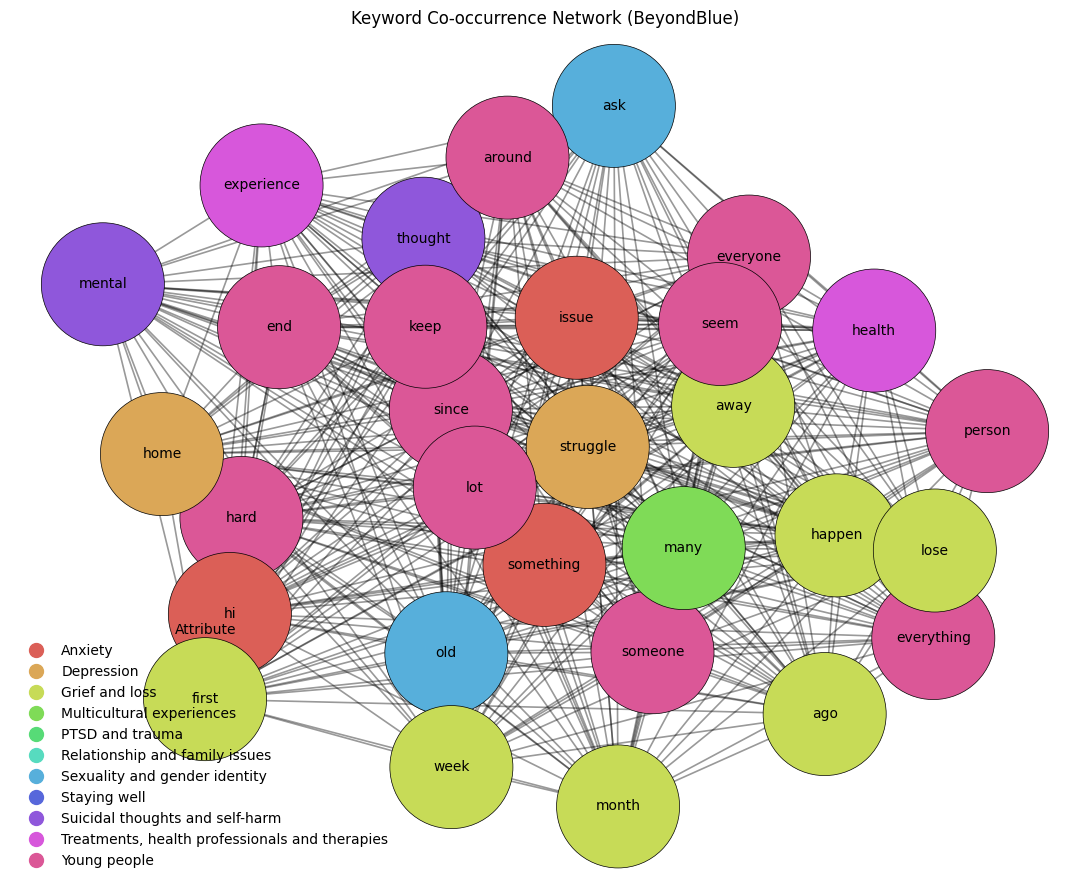

✅  Gephi files saved to: data\beyondblue_data\Gephi_Network


In [21]:
import os
import itertools
from collections import Counter, defaultdict

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# ────────────────────────────────────────────────────────────
#  USER‑ADJUSTABLE CONSTANTS
# ────────────────────────────────────────────────────────────
TOP_N = 30        # how many most‑connected nodes to display
MIN_DEGREE = 2    # drop nodes with degree < MIN_DEGREE from full graph
LAYOUT_K = 2.0    # spring layout repulsion
LAYOUT_ITER = 150 # spring layout iterations
FIGSIZE = (11, 9)
OUTDIR = os.path.join("data", "beyondblue_data", "Gephi_Network")
os.makedirs(OUTDIR, exist_ok=True)

# ────────────────────────────────────────────────────────────
#  LOAD DATA
# ────────────────────────────────────────────────────────────
current_dir = os.getcwd()
csv_path = os.path.join(
    current_dir, "data", "beyondblue_data", "clean",
    "cleaned_beyondblue_all_text_2015up.csv"
)


# sample: keep for debugging
# shuffle the DataFrame to randomise order
df = pd.read_csv(csv_path).copy().sample(frac=1, random_state=42).reset_index(drop=True).head(1000)  

# ────────────────────────────────────────────────────────────
#  TOKENISE
#  (replace this with your NLP_OPERATORS().text_preprocessing)
# ────────────────────────────────────────────────────────────
clean_operator = NLP_OPERATORS()                          # ← your existing helper

df["tokens"] = df["clean_title_content_comments"].apply(
    lambda x: clean_operator.text_preprocessing(x, return_tokens=True)
)

# ────────────────────────────────────────────────────────────
#  BUILD EDGE LIST (co‑occurrence counts)
# ────────────────────────────────────────────────────────────
pair_counter = Counter()
for tokens in df["tokens"]:
    pairs = itertools.combinations(set(tokens), 2)       # unique pairs per post
    pair_counter.update(pairs)

G = nx.Graph()
for (a, b), w in pair_counter.items():
    G.add_edge(a, b, weight=w)

# ────────────────────────────────────────────────────────────
#  OPTIONAL: filter low‑degree nodes to declutter
# ────────────────────────────────────────────────────────────
for n in list(G.nodes):
    if G.degree(n) < MIN_DEGREE:
        G.remove_node(n)

# ────────────────────────────────────────────────────────────
#  CREATE TOP‑N SUBGRAPH (visually cleaner)
# ────────────────────────────────────────────────────────────
top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[60:90]
G_top = G.subgraph([n for n, _ in top_nodes]).copy()

# ────────────────────────────────────────────────────────────
#  COLOUR NODES BY MOST‑COMMON ATTRIBUTE
# ────────────────────────────────────────────────────────────
attribute_col = "Post Category"
keyword_attr_count = defaultdict(Counter)

if attribute_col in df.columns:
    for tokens, attr in zip(df["tokens"], df[attribute_col]):
        for t in set(tokens):
            keyword_attr_count[t][attr] += 1

    # dominant attribute per keyword
    keyword_dominant = {
        k: v.most_common(1)[0][0] for k, v in keyword_attr_count.items()
    }

    unique_attrs = sorted(df[attribute_col].dropna().unique())
    palette = sns.color_palette("hls", len(unique_attrs)).as_hex()
    attr_color = dict(zip(unique_attrs, palette))
else:
    keyword_dominant = {}
    attr_color = {}

# colour list for nodes in G_top
node_colors = [
    attr_color.get(keyword_dominant.get(n, None), "#9e9e9e")  # grey fallback
    for n in G_top.nodes
]

# ────────────────────────────────────────────────────────────
#  DRAW GRAPH
# ────────────────────────────────────────────────────────────
plt.figure(figsize=FIGSIZE)
pos = nx.spring_layout(G_top, k=LAYOUT_K, iterations=LAYOUT_ITER)

node_sizes = [600 + 250 * G_top.degree(n) for n in G_top.nodes]

nx.draw_networkx_nodes(G_top, pos,
                       node_color=node_colors,
                       node_size=node_sizes,
                       linewidths=0.5,
                       edgecolors="black")
nx.draw_networkx_edges(G_top, pos, alpha=0.4, width=1.2)
nx.draw_networkx_labels(G_top, pos, font_size=10)

plt.title("Keyword Co‑occurrence Network (BeyondBlue)")
plt.axis("off")

# add legend if attributes exist
if attr_color:
    for attr, col in attr_color.items():
        plt.plot([], [], "o", label=attr, markersize=10, color=col)
    plt.legend(frameon=False, title="Attribute", loc="lower left")

plt.tight_layout()
plt.show()

# ────────────────────────────────────────────────────────────
#  EXPORT FOR GEPHI
# ────────────────────────────────────────────────────────────
nodes_df = pd.DataFrame({"Id": list(G_top.nodes), "Label": list(G_top.nodes)})
edges_df = nx.to_pandas_edgelist(G_top)

nodes_df.to_csv(os.path.join(OUTDIR, "Gephi_nodes.csv"), index=False)
edges_df.to_csv(os.path.join(OUTDIR, "Gephi_edges.csv"), index=False)

print("✅  Gephi files saved to:", OUTDIR)


# CATEGORIZATION

In [ ]:
general_symptom_categories = [
    "Depression",
    "Anxiety",
    "Stress/Burnout",
    "Loneliness",
    "Low Self-Esteem",
    "Trauma/PTSD",
    "Anger/Irritability",
    "Obsessive Thoughts",
    "Addiction"
]

suicide_and_selfharm_labels = [
    "Suicidal Ideation",
    "Suicide Attempt",
    "Self-Harm",
    "Despair",
    "Urgent Help Request",
    "Grief After Suicide",
    "Coping with Suicidal Thoughts"
]

# MODEL TRAINING